Hyperparameter varied- Optimization by varying the learning rate

Necessary imports

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2022-07-29 01:28:59.617225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 01:28:59.617252: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Setting the hyperparameters of the model

In [10]:
n_epochs=10
n_layers=1
n_train = 250    # Size of the train dataset
n_test = 50     # Size of the test dataset

In [11]:
SAVE_PATH="/home/user/Desktop/impli/"
PREPROCESS=True
np.random.seed(0)
tf.random.set_seed(0)

loading the data

In [12]:
mnist_dataset=keras.datasets.mnist
(train_images,train_labels),(test_images,test_labels)=mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

test_images.shape

(50, 28, 28)

normalising the data

In [13]:
train_images=train_images/255
test_images=test_images/255
train_images.shape

(250, 28, 28)

adding extra dimension for convolution channels

In [14]:
train_images=np.array(train_images[...,tf.newaxis],requires_grad=False)
test_images=np.array(test_images[...,tf.newaxis],requires_grad=False)#requires_grad??
train_images.shape

(250, 28, 28, 1)

initilaizing a default.qubit device simulating a system of 4 qubits

In [15]:
dev = qml.device("default.qubit", wires=4)

Initialising random parameters

In [16]:
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))#1 x 4 returned as tensor
rand_params

tensor([[3.44829694, 4.49366732, 3.78727399, 3.42360201]], requires_grad=True)

qnode consists of a quantum function and a device on which it executes

In [17]:
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)#an embedding layer of local Ry rotations

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))#a random circuit of n_layers rand_params is the weight first argument of weight is the number of layers and the second argument of weights is the number of rotations

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]#measurement in the computational basis

drawing the circuit for illustration purposes with random parameters

In [18]:
drawer = qml.draw(circuit)
print(drawer([1,2,3,4]))

0: ──RY(3.14)──╭RandomLayers(M0)─┤  <Z>
1: ──RY(6.28)──├RandomLayers(M0)─┤  <Z>
2: ──RY(9.42)──├RandomLayers(M0)─┤  <Z>
3: ──RY(12.57)─╰RandomLayers(M0)─┤  <Z>


Convolution the input image with many applications of the same quantum circuit.

In [19]:
def quanv(image):
    out = np.zeros((14, 14, 4))#initilaising output image with 4 different channels

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):#the 4 expectation values are mapped into 4 different channels of a single output pixel
                out[j // 2, k // 2, c] = q_results[c]
    return out


preprocessing the train and test images as the quanvoluional layer isnt trained

In [20]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1,n_test ), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

    print(q_train_images.shape)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
250/250        
Quantum pre-processing of test images:
(250, 14, 14, 4)


In [23]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(14,14,4)))#convolution layer
    model.add(MaxPool2D(2,2))#pooling layer

    model.add(Flatten())#flattening to form 1 D array
    model.add(Dense(100,activation='relu'))# hidden layer
    model.add(Dense(10,activation='softmax'))#output layer

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    batch_size=16,
    epochs=170,
    verbose=2,validation_data=(q_test_images, test_labels),
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-3 * 10 ** (epoch / 30)
        )]
)

Epoch 1/170
16/16 - 1s - loss: 2.1085 - accuracy: 0.2560 - val_loss: 1.7623 - val_accuracy: 0.4400 - lr: 0.0010 - 949ms/epoch - 59ms/step
Epoch 2/170
16/16 - 0s - loss: 1.2995 - accuracy: 0.7280 - val_loss: 1.3271 - val_accuracy: 0.5800 - lr: 0.0011 - 110ms/epoch - 7ms/step
Epoch 3/170
16/16 - 0s - loss: 0.7372 - accuracy: 0.8400 - val_loss: 0.8940 - val_accuracy: 0.6800 - lr: 0.0012 - 176ms/epoch - 11ms/step
Epoch 4/170
16/16 - 0s - loss: 0.4386 - accuracy: 0.9080 - val_loss: 0.7128 - val_accuracy: 0.7200 - lr: 0.0013 - 169ms/epoch - 11ms/step
Epoch 5/170
16/16 - 0s - loss: 0.2794 - accuracy: 0.9320 - val_loss: 0.5690 - val_accuracy: 0.8000 - lr: 0.0014 - 148ms/epoch - 9ms/step
Epoch 6/170
16/16 - 0s - loss: 0.1897 - accuracy: 0.9600 - val_loss: 0.5637 - val_accuracy: 0.8200 - lr: 0.0015 - 143ms/epoch - 9ms/step
Epoch 7/170
16/16 - 0s - loss: 0.1439 - accuracy: 0.9680 - val_loss: 0.4870 - val_accuracy: 0.8400 - lr: 0.0016 - 154ms/epoch - 10ms/step
Epoch 8/170
16/16 - 0s - loss: 0.0829

Evaluation of model

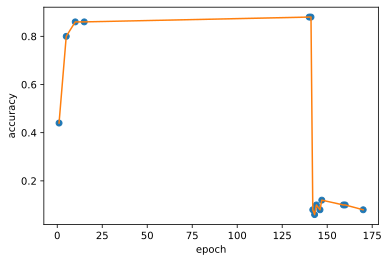

In [4]:
import numpy as np
import matplotlib.pyplot as plt
x=np.array([1,5,10,15,140,141,142,143,144,146,147,159,160,170])
y=np.array([0.4400,0.8000,0.8600,0.8600,0.8800,0.8800,0.0800,0.0600,0.1000,0.0800,0.1200,0.1000,0.1000,0.0800])

plt.plot(x,y,'o')
plt.plot(x,y)
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.show()